In [1]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [5]:
!conda install dask -y

Channels:
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /share/apps/python/anaconda-3.14

  added / updated specs:
    - dask


The following NEW packages will be INSTALLED:

  arrow-cpp          pkgs/main/linux-64::arrow-cpp-16.1.0-hc1eb8f0_0 
  aws-c-auth         pkgs/main/linux-64::aws-c-auth-0.6.19-h5eee18b_0 
  aws-c-cal          pkgs/main/linux-64::aws-c-cal-0.5.20-hdbd6064_0 
  aws-c-common       pkgs/main/linux-64::aws-c-common-0.8.5-h5eee18b_0 
  aws-c-compression  pkgs/main/linux-64::aws-c-compression-0.2.16-h5eee18b_0 
  aws-c-event-stream pkgs/main/linux-64::aws-c-event-stream-0.2.15-h6a678d5_0 
  aws-c-http         pkgs/main/linux-64::aws-c-http-0.6.25-h5eee18b_0 
  aws-c-io           pkgs/main/linux-64::aws-c-io-0.13.10-h5eee18b_0 
  aws-c-mqtt         pkgs/main/linux-64::aws-c-mqtt-0.7.13-h5eee18b_0 
  aws-c-s3           pkgs/main/linux-64::aws-c-s3-0.1.51-hdbd6064_0 
  aws-c-sdkutils     pkgs/main/li

In [6]:
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable


In [7]:
!pip install -U sentence-transformers

Defaulting to user installation because normal site-packages is not writeable


In [80]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.7/163.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 51.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 54.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 12.2 MB/s eta 0:00:00


In [29]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
import os
import pandas as pd
import pyarrow
import dask.dataframe as dd
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [2]:
examples_path = os.path.join('..', 'data', 'shopping_queries_dataset_examples.parquet')
products_path = os.path.join('..', 'data', 'shopping_queries_dataset_products.parquet')
sources_path = os.path.join('..', 'data', 'shopping_queries_dataset_sources.csv')

examples = dd.read_parquet(examples_path)
products = dd.read_parquet(products_path)
sources = dd.read_csv(sources_path)

In [3]:
examples_products = dd.merge(
    examples,
    products,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)

examples_products = examples_products[examples_products['product_locale'] == 'us']

task_2 = examples_products[examples_products['large_version'] == 1]

label_mapping = {'E': 0, 
                 'S': 1, 
                 'C': 2, 
                 'I': 3}

task_2['encoded_labels'] = task_2['esci_label'].map(label_mapping).astype(int)

task_2_train = task_2[task_2['split'] == 'train']
task_2_test = task_2[task_2['split'] == 'test']

/home/sllawlis/python3.14/lib/python3.11/site-packages/dask_expr/_collection.py:4196: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('esci_label', 'float64'))

  warnings.warn(meta_warning(meta))


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
print(device)

cuda


In [6]:
print(torch.cuda.get_device_name(0))

Tesla V100-PCIE-32GB


# Multilayer Perceptron Class

In [7]:
class FullyConnected(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(FullyConnected, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(p=0.1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        pooled_output_size = hidden_size // 2
        self.fc2 = nn.Linear(pooled_output_size, num_layers)

    def forward(self, x):
        x = torch.flatten(x, 1).float()
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)

        x = self.maxpool(x)
        x = x.view(x.size(0), -1)

        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
class MLPsoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(MLPsoftmax, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(p=0.1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        pooled_output_size = hidden_size // 2
        self.fc2 = nn.Linear(pooled_output_size, num_layers)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.flatten(x, 1).float()
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)

        x = self.maxpool(x)
        x = x.view(x.size(0), -1)

        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# ESCIDataset Class

In [9]:
class ESCIDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings.values

        print(f'Shape of embeddings: {self.embeddings.shape}')
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [16]:
# class ESCIDataset(torch.utils.data.Dataset):
#     def __init__(self, embeddings, labels):
#         # Ensure embeddings and labels are NumPy arrays
#         self.embeddings = np.array(embeddings)
#         self.labels = np.array(labels)

#         print(f"Shape of embeddings: {self.embeddings.shape}")
#         print(f"Shape of labels: {self.labels.shape}")

#     def __len__(self):
#         return len(self.embeddings)

#     def __getitem__(self, idx):
#         if idx >= len(self.embeddings):
#             raise IndexError(f"Index {idx} out of bounds for embeddings of size {len(self.embeddings)}")
#         return self.embeddings[idx], self.labels[idx]

# distilbert-base-uncased

In [73]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

for param in model.parameters():
    param.requires_grad = False

def generate_embeddings(texts):
    batch_size = 128  # Adjust this size
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

def process_partition(partition):
    query_embeddings = generate_embeddings(partition['query'])
    product_title_embeddings = generate_embeddings(partition['product_title'])

    combined = torch.cat((torch.tensor(query_embeddings), torch.tensor(product_title_embeddings)), dim=1).numpy()
    
    print(f'Combined shape: {combined.shape}')  # expecting (n, 1536)

    result = pd.DataFrame(combined, index=partition.index, columns=[f'embedding_{i}' for i in range(combined.shape[1])])

    return result

In [74]:
print(torch.cuda.get_device_name(0))

Tesla V100-PCIE-32GB


In [75]:
meta = pd.DataFrame(columns=[f'embedding_{i}' for i in range(2 * 768)], dtype='float64')

In [12]:
# total_rows = task_2_train.shape[0].compute()

# sample_fraction = 10000 / total_rows

# task_2_train_sample = task_2_train.sample(frac=sample_fraction, random_state=42)

In [13]:
result_train = task_2_train.map_partitions(process_partition, meta=meta)

In [14]:
embedding_columns = [f'embedding_{i}' for i in range(1536)]

In [15]:
print(embedding_columns)

['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7', 'embedding_8', 'embedding_9', 'embedding_10', 'embedding_11', 'embedding_12', 'embedding_13', 'embedding_14', 'embedding_15', 'embedding_16', 'embedding_17', 'embedding_18', 'embedding_19', 'embedding_20', 'embedding_21', 'embedding_22', 'embedding_23', 'embedding_24', 'embedding_25', 'embedding_26', 'embedding_27', 'embedding_28', 'embedding_29', 'embedding_30', 'embedding_31', 'embedding_32', 'embedding_33', 'embedding_34', 'embedding_35', 'embedding_36', 'embedding_37', 'embedding_38', 'embedding_39', 'embedding_40', 'embedding_41', 'embedding_42', 'embedding_43', 'embedding_44', 'embedding_45', 'embedding_46', 'embedding_47', 'embedding_48', 'embedding_49', 'embedding_50', 'embedding_51', 'embedding_52', 'embedding_53', 'embedding_54', 'embedding_55', 'embedding_56', 'embedding_57', 'embedding_58', 'embedding_59', 'embedding_60', 'embedding_61', 'embedding_62', '

In [24]:
# result_train = result_train.compute()

In [25]:
total_rows2 = task_2_test.shape[0].compute()

sample_fraction2 = 10000 / total_rows2

task_2_test_sample = task_2_test.sample(frac=sample_fraction2, random_state=42)

# query_texts = task_2_test_sample['query'].tolist()
# product_titles = task_2_test_sample['product_title'].tolist()

In [26]:
result_test = task_2_test.map_partitions(process_partition, meta=meta)

In [27]:
# result_test = result_test.compute()

In [28]:
# result

In [29]:
# result_test.to_parquet('/home/sllawlis/esci-shopping-queries/data/distilbert_embeddings_train.parquet')
# result_train.to_parquet('/home/sllawlis/esci-shopping-queries/data/distilbert_embeddings_test.parquet')

In [30]:
# result_train_dd = dd.read_parquet('/home/sllawlis/esci-shopping-queries/data/distilbert_embeddings_train.parquet')
# result_test_dd = dd.read_parquet('/home/sllawlis/esci-shopping-queries/data/distilbert_embeddings_test.parquet')

In [76]:
result_train = pd.read_csv('/home/sllawlis/esci-shopping-queries/data/distilbert_embeddings_train.csv', index_col=0)
result_test = pd.read_csv('/home/sllawlis/esci-shopping-queries/data/distilbert_embeddings_test.csv', index_col=0)

In [13]:

# Convert to Pandas DataFrames for inspection and processing if the size is manageable
result_train = result_train.compute()
result_test = result_test.compute()

AttributeError: 'DataFrame' object has no attribute 'compute'

In [14]:
len(result_train)

425762

In [15]:
# Converting from DASK to Pandas 
task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

In [77]:
input_size = 1536
hidden_size = 128
num_layers = 4

model = FullyConnected(input_size, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01)

In [78]:
task_2_train_indices = task_2_train.index.astype(int)
subset_labels = task_2_train['encoded_labels']
subset_labels = subset_labels.to_frame()

task_2_test_indices = task_2_test.index.astype(int)
subset_labels2 = task_2_test['encoded_labels']
subset_labels2 = subset_labels2.to_frame()

In [79]:
subset_labels = subset_labels.iloc[:len(result_train)].reset_index(drop=True)

In [38]:
# subset_indices2 = result2.index
# subset_indices2 = subset_indices2.astype(int)
# task_2_test_indices = task_2_test.index.astype(int)
 
# valid_indices2 = task_2_test_indices[task_2_test_indices.isin(subset_indices2)]
# subset_labels2 = task_2_test.loc[valid_indices2, 'encoded_labels'] 
# subset_labels2 = subset_labels2.to_frame()

In [80]:
result_train = result_train.sort_index()
result_test = result_test.sort_index()

In [81]:
result_train = result_train.astype('float32')
result_test = result_test.astype('float32')

In [82]:
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Shape of embeddings: (425762, 1536)


In [66]:
# train_dataset = ESCIDataset(embeddings=result_train.values, labels=subset_labels['encoded_labels'].values)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [83]:
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (1393063, 1536)


In [84]:
for inputs, labels in test_loader:
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

In [ ]:
print("Type of embeddings:", type(train_dataset.embeddings))
print("Type of labels:", type(train_dataset.labels))

In [70]:
print(f"Embeddings shape: {len(result_train)}")
print(f"Labels shape: {len(subset_labels)}")

Embeddings shape: 425762
Labels shape: 425762


In [85]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=4):
    model.train()  # set model to training mode
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (embeddings, labels) in enumerate(train_loader):
            embeddings, labels = embeddings.to(device), labels.to(device)

            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(embeddings.float())  # Forward pass
            # converting the labels to long in order to 
            labels = labels.long()
            # calculate the loss 
            loss = criterion(outputs, labels) 
            # backpropogation 
            loss.backward() 
            # updating the weights 
            optimizer.step()  

            # add up the loss 
            epoch_loss += loss.item()  

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

# run the training model with the 10000 samples 
train_model(model, train_loader, criterion, optimizer)

Epoch 1/4, Loss: 0.8931
Epoch 2/4, Loss: 0.8909
Epoch 3/4, Loss: 0.8911
Epoch 4/4, Loss: 0.8910


In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=4):
    model.train()  # set model to training mode
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (embeddings, labels) in enumerate(train_loader):
            embeddings, labels = embeddings.to(device), labels.to(device)
            
            # Ensure embeddings are in float32
            embeddings = embeddings.float()
            
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(embeddings)  # Forward pass
            
            # Ensure labels are of type long
            labels = labels.long()

            # Calculate the loss
            loss = criterion(outputs, labels) 

            # Backpropagation
            loss.backward()
            
            # Update the weights
            optimizer.step()  

            # Add up the loss
            epoch_loss += loss.item()  

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)

In [86]:
def evaluate_model(test_loader, model):
    model = model.float()
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device).float()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # evaluate on the f1 score with micro averages
    return f1_score(all_labels, all_preds, average='micro')

In [87]:
f1 = evaluate_model(test_loader, model)
print(f'Micro F1 Score: {f1:.4f}')

Micro F1 Score: 0.6514


In [88]:
def evaluate_and_capture_mismatches(test_loader, model, task_2_test):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # convert task_2_test to pandas df if it's a dask df
    if hasattr(task_2_test, 'compute'):
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']].compute()
    else:
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']]

    test_df['predicted_label'] = all_preds
    test_df['true_label'] = all_labels
    
    mismatch_df = test_df[test_df['true_label'] != test_df['predicted_label']]
    
    # added test to make the confusion matrix 
    return test_df, mismatch_df

test_df, mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_232765/3143127466.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_232765/3143127466.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


In [89]:
# count top 10mismatches per query
mismatch_counts_per_query = mismatch_df['query'].value_counts().head(10) 
mismatch_counts_per_product = mismatch_df['product_title'].value_counts().head(10)

all_text = ' '.join(mismatch_df['query'].tolist() + mismatch_df['product_title'].tolist())
word_counts = Counter(all_text.split()).most_common(10)  # Top 10 common words

print("Top 10 queries with the most mismatches:\n", mismatch_counts_per_query)
print("\nTop 10 most common words in mismatched entries:\n", word_counts)

Top 10 queries with the most mismatches:
 query
fitbit charge 3                            65
apple earbuds                              60
firestick                                  56
airpods 2                                  53
dek pro                                    48
futon frames full size without mattress    48
kindle                                     46
keep grinding hat                          42
marvel against humanity game               42
shaggy dog board game                      42
Name: count, dtype: int64[pyarrow]

Top 10 most common words in mismatched entries:
 [('for', 66849), ('-', 45241), ('with', 39985), ('and', 38192), ('&', 19424), ('of', 15107), ('|', 11940), ('Black', 11808), ('without', 10697), ('to', 9763)]


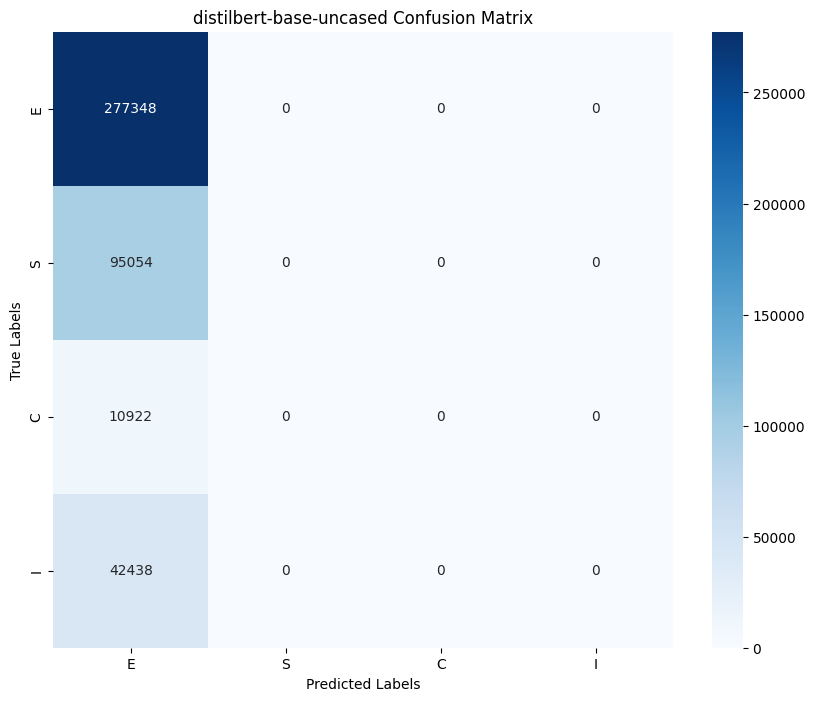

In [90]:
true_labels = test_df['true_label']
predicted_labels = test_df['predicted_label']

fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'S', 'C', 'I'], yticklabels=['E', 'S', 'C', 'I'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('distilbert-base-uncased Confusion Matrix')
plt.show()

# TinyBERT

In [91]:
# Load model directly
from transformers import AutoModel
model = AutoModel.from_pretrained("prajjwal1/bert-tiny")

In [92]:
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')
model = BertModel.from_pretrained('prajjwal1/bert-tiny').to(device)

for param in model.parameters():
    param.requires_grad = False

def generate_embeddings(texts):
    batch_size = 128  # Adjust this size
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

def process_partition(partition):
    query_embeddings = generate_embeddings(partition['query'])
    product_title_embeddings = generate_embeddings(partition['product_title'])

    combined = torch.cat((torch.tensor(query_embeddings), torch.tensor(product_title_embeddings)), dim=1).numpy()
    
    print(f'Combined shape: {combined.shape}')  # expecting (n, 1536)

    result = pd.DataFrame(combined, index=partition.index, columns=[f'embedding_{i}' for i in range(combined.shape[1])])

    return result

In [80]:
meta = pd.DataFrame(columns=[f'embedding_{i}' for i in range(2 * 128)], dtype='float64')

# result_train = task_2_train.map_partitions(process_partition, meta=meta)

# result_train = result_train.compute()

# result_train = np.genfromtxt('/home/sllawlis/esci-shopping-queries/data/tinybert_embeddings_train.csv')
# result2 = np.genfromtxt('/home/sllawlis/esci-shopping-queries/data/tinybert_embeddings_test.csv')

In [81]:
result_test = task_2_test.map_partitions(process_partition, meta=meta)

# result_test = result_test.compute()

AttributeError: 'DataFrame' object has no attribute 'map_partitions'

In [20]:
# result_train.to_parquet('/home/sllawlis/esci-shopping-queries/data/tinybert_embeddings_train.parquet')
# result_test.to_parquet('/home/sllawlis/esci-shopping-queries/data/tinybert_embeddings_test.parquet')

In [93]:
result_train = pd.read_csv('/home/sllawlis/esci-shopping-queries/data/tinybert_embeddings_train.csv', index_col=0)
result_test = pd.read_csv('/home/sllawlis/esci-shopping-queries/data/tinybert_embeddings_test.csv', index_col=0)

In [83]:
task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

AttributeError: 'DataFrame' object has no attribute 'compute'

In [94]:
input_size = 256
hidden_size = 128
num_layers = 4

model = FullyConnected(input_size, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01)

In [84]:
input_size = 256
hidden_size = 128
num_layers = 4

model = MLPsoftmax(input_size, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01)

In [95]:
task_2_train_indices = task_2_train.index.astype(int)
subset_labels = task_2_train['encoded_labels']
subset_labels = subset_labels.to_frame()

task_2_test_indices = task_2_test.index.astype(int)
subset_labels2 = task_2_test['encoded_labels']
subset_labels2 = subset_labels2.to_frame()

In [96]:
result_train = result_train.sort_index()
result_test = result_test.sort_index()

In [97]:
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Shape of embeddings: (1393063, 256)


In [98]:
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (425762, 256)


In [99]:
for inputs, labels in test_loader:
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

In [29]:
# def train_model(model, train_loader, criterion, optimizer, num_epochs=4):
#     model.train()  # set model to training mode
#     for epoch in range(num_epochs):
#         epoch_loss = 0
#         for batch_idx, (embeddings, labels) in enumerate(train_loader):
#             embeddings, labels = embeddings.to(device), labels.to(device)

#             optimizer.zero_grad()  # Clear previous gradients
#             outputs = model(embeddings.float())  # Forward pass
#             # converting the labels to long in order to 
#             labels = labels.long()
#             # calculate the loss 
#             loss = criterion(outputs, labels) 
#             # backpropogation 
#             loss.backward() 
#             # updating the weights 
#             optimizer.step()  

#             # add up the loss 
#             epoch_loss += loss.item()  

#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

# # run the training model with the 10000 samples 
# train_model(model, train_loader, criterion, optimizer)

In [100]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=4):
    model.train()  # set model to training mode
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (embeddings, labels) in enumerate(train_loader):
            embeddings, labels = embeddings.to(device), labels.to(device)
            
            # Ensure embeddings are in float32
            embeddings = embeddings.float()
            
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(embeddings)  # Forward pass
            
            # Ensure labels are of type long
            labels = labels.long()

            # Calculate the loss
            loss = criterion(outputs, labels) 

            # Backpropagation
            loss.backward()
            
            # Update the weights
            optimizer.step()  

            # Add up the loss
            epoch_loss += loss.item()  

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)

Epoch 1/4, Loss: 0.8262
Epoch 2/4, Loss: 0.8159
Epoch 3/4, Loss: 0.8129
Epoch 4/4, Loss: 0.8111


In [91]:
def train_model_without_loss(model, train_loader, num_epochs=4):
    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        for batch_idx, (embeddings, labels) in enumerate(train_loader):
            # Move embeddings and labels to the device
            embeddings = embeddings.to(device).float()
            
            # Forward pass to get probabilities
            outputs = model(embeddings)  # Outputs are softmax probabilities
            
            # Store or analyze the probabilities
            # For example, you can print the first batch probabilities
            if batch_idx == 0:
                print(f"Batch {batch_idx + 1} probabilities:\n{outputs[:5]}") 
                
train_model_without_loss(model, train_loader)

Epoch 1/4
Batch 1 probabilities:
tensor([[9.9861e-01, 5.8040e-04, 3.7162e-04, 4.3585e-04],
        [9.9663e-01, 1.3748e-03, 9.2709e-04, 1.0668e-03],
        [9.9640e-01, 1.4647e-03, 9.9199e-04, 1.1407e-03],
        [9.9632e-01, 1.4955e-03, 1.0149e-03, 1.1661e-03],
        [9.9642e-01, 1.4563e-03, 9.8572e-04, 1.1335e-03]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 2/4
Batch 1 probabilities:
tensor([[9.9838e-01, 6.7512e-04, 4.3657e-04, 5.1008e-04],
        [9.9573e-01, 1.7298e-03, 1.1836e-03, 1.3561e-03],
        [9.9739e-01, 1.0723e-03, 7.1211e-04, 8.2434e-04],
        [9.9608e-01, 1.5910e-03, 1.0834e-03, 1.2433e-03],
        [9.9828e-01, 7.1448e-04, 4.6360e-04, 5.4116e-04]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 3/4
Batch 1 probabilities:
tensor([[9.9610e-01, 1.5843e-03, 1.0777e-03, 1.2372e-03],
        [9.9829e-01, 7.0964e-04, 4.6013e-04, 5.3711e-04],
        [9.9841e-01, 6.6332e-04, 4.2830e-04, 5.0065e-04],
        [9.9767e-01, 9.6238e-04, 6.3489e-04, 

In [93]:
all_probabilities = []

for batch_idx, (embeddings, labels) in enumerate(train_loader):
    embeddings = embeddings.to(device).float()
    outputs = model(embeddings)
    all_probabilities.append(outputs.detach().cpu().numpy())  # Append to list

# Combine all probabilities into a single array
import numpy as np
all_probabilities = np.vstack(all_probabilities)

In [101]:
def evaluate_model(test_loader, model):
    model = model.float()
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device).float()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # evaluate on the f1 score with micro averages
    return f1_score(all_labels, all_preds, average='micro')

In [102]:
f1 = evaluate_model(test_loader, model)
print(f'Micro F1 Score: {f1:.4f}')

Micro F1 Score: 0.6549


In [103]:
def evaluate_and_capture_mismatches(test_loader, model, task_2_test):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # convert task_2_test to pandas df if it's a dask df
    if hasattr(task_2_test, 'compute'):
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']].compute()
    else:
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']]

    test_df['predicted_label'] = all_preds
    test_df['true_label'] = all_labels
    
    mismatch_df = test_df[test_df['true_label'] != test_df['predicted_label']]
    
    # added test to make the confusion matrix 
    return test_df, mismatch_df

test_df, mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_232765/3143127466.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_232765/3143127466.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


In [104]:
# count top 10mismatches per query
mismatch_counts_per_query = mismatch_df['query'].value_counts().head(10) 
mismatch_counts_per_product = mismatch_df['product_title'].value_counts().head(10)

all_text = ' '.join(mismatch_df['query'].tolist() + mismatch_df['product_title'].tolist())
word_counts = Counter(all_text.split()).most_common(10)  # Top 10 common words

print("Top 10 queries with the most mismatches:\n", mismatch_counts_per_query)
print("\nTop 10 most common words in mismatched entries:\n", word_counts)

Top 10 queries with the most mismatches:
 query
fitbit charge 3                            65
apple earbuds                              60
firestick                                  56
airpods 2                                  53
dek pro                                    48
futon frames full size without mattress    48
kindle                                     46
shaggy dog board game                      43
keep grinding hat                          42
apple earphones                            40
Name: count, dtype: int64[pyarrow]

Top 10 most common words in mismatched entries:
 [('for', 66248), ('-', 45038), ('with', 39585), ('and', 37489), ('&', 19249), ('of', 14761), ('|', 11785), ('Black', 11649), ('without', 10545), ('to', 9463)]


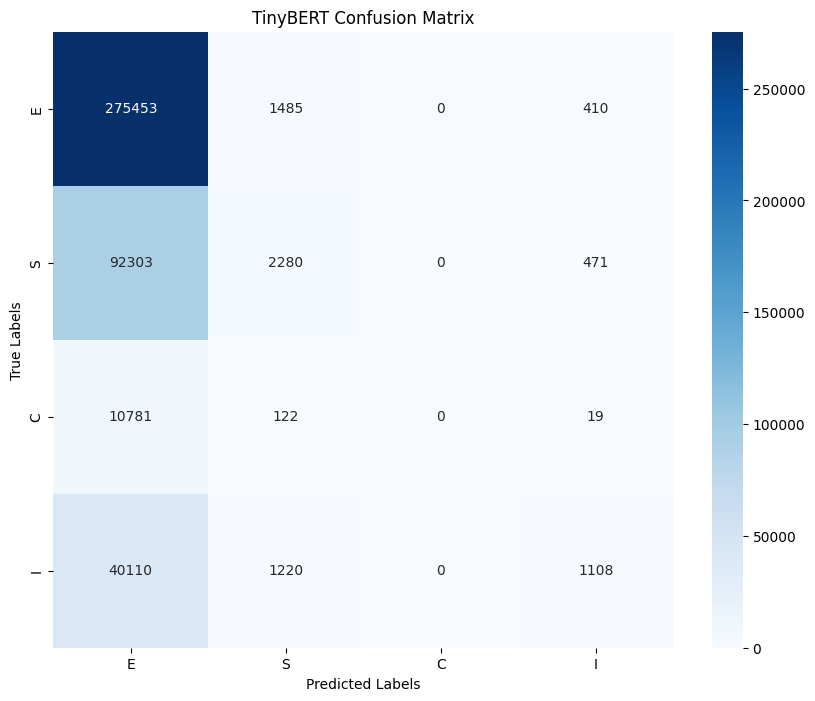

In [105]:
true_labels = test_df['true_label']
predicted_labels = test_df['predicted_label']

fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'S', 'C', 'I'], yticklabels=['E', 'S', 'C', 'I'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('TinyBERT Confusion Matrix')
plt.show()

# all-MiniLM-L6-v2

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
tokenizer = BertTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = BertModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to(device)

for param in model.parameters():
    param.requires_grad = False

def generate_embeddings(texts):
    batch_size = 128  # Adjust this size
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

def process_partition(partition):
    query_embeddings = generate_embeddings(partition['query'])
    product_title_embeddings = generate_embeddings(partition['product_title'])

    combined = torch.cat((torch.tensor(query_embeddings), torch.tensor(product_title_embeddings)), dim=1).numpy()
    
    print(f'Combined shape: {combined.shape}')  # expecting (n, 1536)

    result = pd.DataFrame(combined, index=partition.index, columns=[f'embedding_{i}' for i in range(combined.shape[1])])

    return result

In [ ]:
meta = pd.DataFrame(columns=[f'embedding_{i}' for i in range(2 * 384)], dtype='float64')

# result_train = task_2_train.map_partitions(process_partition, meta=meta)

# result_train = result_train.compute()

In [54]:
# result_test = task_2_test.map_partitions(process_partition, meta=meta)

# result_test = result_test.compute()

Combined shape: (425762, 768)


In [55]:
# result_train.to_csv('/home/sllawlis/esci-shopping-queries/data/all-MiniLM-L6-v2_embeddings_train.csv')
# result_test.to_csv('/home/sllawlis/esci-shopping-queries/data/all-MiniLM-L6-v2_embeddings_test.csv')

In [55]:
result_train = pd.read_csv('/home/sllawlis/esci-shopping-queries/data/all-MiniLM-L6-v2_embeddings_train.csv', index_col=0)
result_test = pd.read_csv('/home/sllawlis/esci-shopping-queries/data/all-MiniLM-L6-v2_embeddings_test.csv', index_col=0)

In [56]:
task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

In [56]:
input_size = 768
hidden_size = 128
num_layers = 4

model = FullyConnected(input_size, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01)

In [57]:
task_2_train_indices = task_2_train.index.astype(int)
subset_labels = task_2_train['encoded_labels']
subset_labels = subset_labels.to_frame()

task_2_test_indices = task_2_test.index.astype(int)
subset_labels2 = task_2_test['encoded_labels']
subset_labels2 = subset_labels2.to_frame()

In [58]:
result_train = result_train.sort_index()
result_test = result_test.sort_index()

In [59]:
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Shape of embeddings: (1393063, 768)


In [60]:
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (425762, 768)


In [61]:
for inputs, labels in test_loader:
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

In [66]:
# def train_model(model, train_loader, criterion, optimizer, num_epochs=4):
#     model.train()  # set model to training mode
#     for epoch in range(num_epochs):
#         epoch_loss = 0
#         for batch_idx, (embeddings, labels) in enumerate(train_loader):
#             embeddings, labels = embeddings.to(device), labels.to(device)

#             optimizer.zero_grad()  # Clear previous gradients
#             outputs = model(embeddings.float())  # Forward pass
#             # converting the labels to long in order to 
#             labels = labels.long()
#             # calculate the loss 
#             loss = criterion(outputs, labels) 
#             # backpropogation 
#             loss.backward() 
#             # updating the weights 
#             optimizer.step()  

#             # add up the loss 
#             epoch_loss += loss.item()  

#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

# # run the training model with all embeddings 
# train_model(model, train_loader, criterion, optimizer)

In [62]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=4):
    model.train()  # set model to training mode
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (embeddings, labels) in enumerate(train_loader):
            embeddings, labels = embeddings.to(device), labels.to(device)
            
            # Ensure embeddings are in float32
            embeddings = embeddings.float()
            
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(embeddings)  # Forward pass
            
            # Ensure labels are of type long
            labels = labels.long()

            # Calculate the loss
            loss = criterion(outputs, labels) 

            # Backpropagation
            loss.backward()
            
            # Update the weights
            optimizer.step()  

            # Add up the loss
            epoch_loss += loss.item()  

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)

Epoch 1/4, Loss: 0.8368
Epoch 2/4, Loss: 0.8296
Epoch 3/4, Loss: 0.8278
Epoch 4/4, Loss: 0.8265


In [63]:
def evaluate_model(test_loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # evaluate on the f1 score with micro averages
    return f1_score(all_labels, all_preds, average='micro')

In [64]:
f1 = evaluate_model(test_loader, model)
print(f'Micro F1 Score: {f1:.4f}')

Micro F1 Score: 0.6515


In [65]:
def evaluate_and_capture_mismatches(test_loader, model, task_2_test):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # convert task_2_test to pandas df if it's a dask df
    if hasattr(task_2_test, 'compute'):
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']].compute()
    else:
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']]

    test_df['predicted_label'] = all_preds
    test_df['true_label'] = all_labels
    
    mismatch_df = test_df[test_df['true_label'] != test_df['predicted_label']]
    
    # added test to make the confusion matrix 
    return test_df, mismatch_df

test_df, mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_232765/3143127466.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_232765/3143127466.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


In [66]:
# count top 10mismatches per query
mismatch_counts_per_query = mismatch_df['query'].value_counts().head(10) 
mismatch_counts_per_product = mismatch_df['product_title'].value_counts().head(10)

all_text = ' '.join(mismatch_df['query'].tolist() + mismatch_df['product_title'].tolist())
word_counts = Counter(all_text.split()).most_common(10)  # Top 10 common words

print("Top 10 queries with the most mismatches:\n", mismatch_counts_per_query)
print("\nTop 10 most common words in mismatched entries:\n", word_counts)

Top 10 queries with the most mismatches:
 query
fitbit charge 3                            65
apple earbuds                              60
firestick                                  56
airpods 2                                  53
dek pro                                    48
futon frames full size without mattress    48
kindle                                     46
keep grinding hat                          42
marvel against humanity game               42
shaggy dog board game                      42
Name: count, dtype: int64[pyarrow]

Top 10 most common words in mismatched entries:
 [('for', 66840), ('-', 45225), ('with', 39972), ('and', 38180), ('&', 19418), ('of', 15106), ('|', 11919), ('Black', 11808), ('without', 10698), ('to', 9764)]


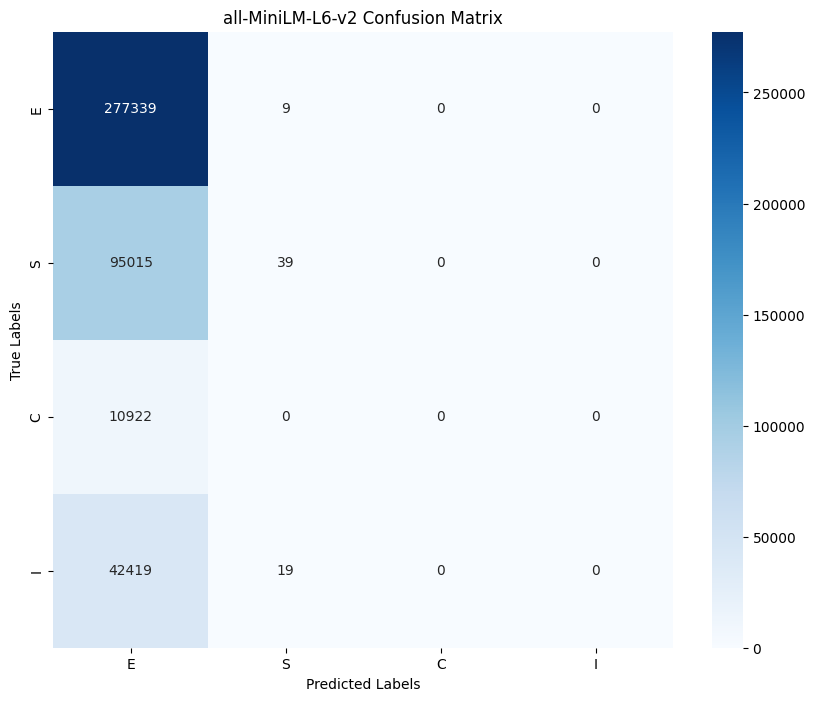

In [72]:
true_labels = test_df['true_label']
predicted_labels = test_df['predicted_label']

fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'S', 'C', 'I'], yticklabels=['E', 'S', 'C', 'I'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('all-MiniLM-L6-v2 Confusion Matrix')
plt.show()